# Allen Institute Visual Behavior 2P dataset overview
### This dataset consists of neural activity measured with 2-photon calcium imaging in the visual cortex of mice performing an image change detection task.
##### In this task, mice learn to report changes in stimulus identity by licking a spout to earn a water reward.


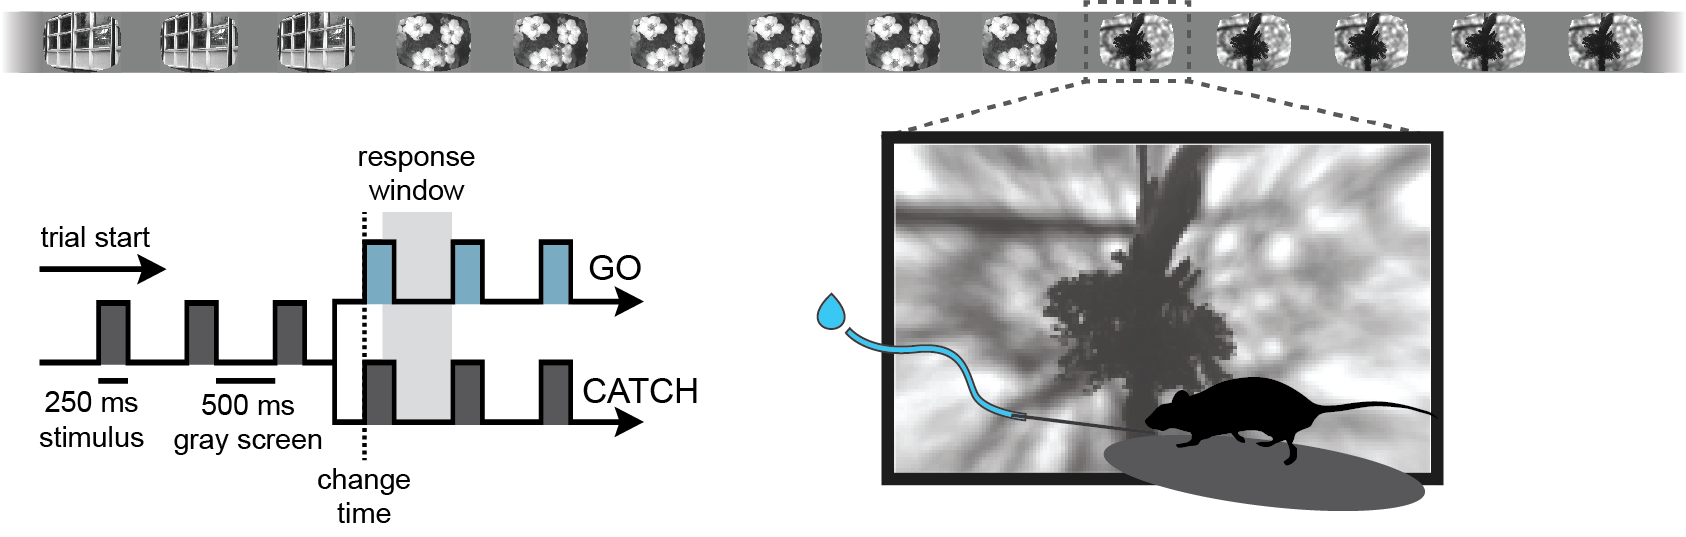

##### In some sessions, the mice perform the task with familiar images they have seen many times during training. In other sessions, mice perform the task with novel images.
##### During 2-photon imaging sessions, 5% of stimulus presentations are randomly omitted, allowing us to examine the effect of unexpected events on neural activity.
##### The same population of cells is imaged over multiple days with varying sensory and behavioral conditions.


##### Multiple cortical areas and depths were measured concurently in each session, at a sample rate of 11Hz.
##### Data was collected from excitatory and inhibitory neural populations.

#### You can learn more about this dataset, behavioral task, and find other useful tools here:
#### [Overview page](https://allenswdb.github.io/physiology/ophys/visual-behavior/VB-Ophys.html) and [Allen Brain Atlas](allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html)
#### This example will focus on the activity of the two inhibitory types - VIP and SST neurons.

# Loading the data

In [22]:
# @title Install dependencies

!pip install pip --upgrade --quiet
!pip install pandas --quiet
!pip install seaborn --quiet
!pip install numpy scipy matplotlib ipython jupyter pandas sympy nose --quiet
!pip install allensdk
!pip install brain_observatory_utilities --upgrade --quiet

In [23]:
# Imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as ophys_formatting
import brain_observatory_utilities.utilities.general_utilities as utilities

from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

pd.set_option('display.max_columns', 500)

## For this example, we have pre-computed event triggered responses and saved them to figshare.
#### To access the full dataset, see `Allen_neuromatch_example_2.ipynb`, or go to the links at the bottom of this notebook
###This cell will download the responses.

In [24]:
# @title Data retrieval
import os, requests

fname = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
url = "https://ndownloader.figshare.com/files/28470255"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

### Then we open it using the pandas `read_parquet` method


(parquet is just another file format)

In [25]:
# filename = "allen_visual_behavior_2p_change_detection_familiar_novel_image_sets.parquet"
# data = pd.read_parquet(filename)

In [50]:
data_storage_directory = "./temp"  # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

def get_experiments(ophys_experiment_ids):
    experiments = {}
    # for ophys_session_id in ophys_session_ids:
    #   ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
    for ophys_experiment_id in ophys_experiment_ids:
        experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)
    return experiments

def get_neural_data(experiments):
    neural_data = []
    for ophys_experiment_id in tqdm(experiments): #tqdm is a package that shows progress bars for items that are iterated over
        this_experiment = experiments[ophys_experiment_id]
        this_experiment_neural_data = ophys_formatting.build_tidy_cell_df(this_experiment)

        # add some columns with metadata for the experiment
        metadata_keys = [
            'ophys_experiment_id',
            'ophys_session_id',
            'targeted_structure',
            'imaging_depth',
            'equipment_name',
            'cre_line',
            'mouse_id',
            'sex',
        ]
        for metadata_key in metadata_keys:
            this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]

        # append the data for this experiment to a list
        neural_data.append(this_experiment_neural_data)

    # concatate the list of dataframes into a single dataframe
    neural_data = pd.concat(neural_data)
    return neural_data

/Users/michealmyers/anaconda3/lib/python3.10/site-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [27]:
all_session_ids = session_table.index.tolist()
e_session_ids = session_table.query('cre_line == "Slc17a7-IRES2-Cre"').index.tolist()
sst_session_ids = session_table.query('cre_line == "Sst-IRES-Cre"').index.tolist()
vip_session_ids = session_table.query('cre_line == "Vip-IRES-Cre"').index.tolist()

all_experiments = experiment_table[experiment_table["ophys_session_id"].isin(all_session_ids)]
e_experiments = experiment_table[experiment_table["ophys_session_id"].isin(e_session_ids)]
sst_experiments = experiment_table[experiment_table["ophys_session_id"].isin(sst_session_ids)]
vip_experiments = experiment_table[experiment_table["ophys_session_id"].isin(vip_session_ids)]

In [28]:
def get_shallow_deep(exp):
    shallow = exp.query('imaging_depth < 250')
    deep = exp.query('imaging_depth >= 250')
    return shallow, deep

e_shallow, e_deep = get_shallow_deep(e_experiments)
sst_shallow, sst_deep = get_shallow_deep(sst_experiments)
vip_shallow, vip_deep = get_shallow_deep(vip_experiments)

In [30]:
e_shallow.iloc[0]

behavior_session_id                                                        877287655
ophys_session_id                                                           877103886
ophys_container_id                                                         876693090
mouse_id                                                                      449441
indicator                                                                    GCaMP6s
full_genotype                      Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai94(TITL-G...
driver_line                                          [Slc17a7-IRES2-Cre, Camk2a-tTA]
cre_line                                                           Slc17a7-IRES2-Cre
reporter_line                                                     Ai94(TITL-GCaMP6s)
sex                                                                                M
age_in_days                                                                      129
imaging_depth                                                    

In [35]:
def pick_one_exp_then_combine_exp_ids(exp_list):
    combined_id_list = []
    for exp in exp_list:
        combined_id_list.append(exp.iloc[0].name)
    return combined_id_list

exp_ids_to_download = pick_one_exp_then_combine_exp_ids([e_shallow, e_deep, sst_shallow, sst_deep, vip_shallow, vip_deep])
exp_ids_to_download

[877696762, 986518878, 951980471, 951980486, 792815735, 1008408508]

In [38]:
exp_download = get_experiments(exp_ids_to_download)

/Users/michealmyers/anaconda3/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Users/michealmyers/anaconda3/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Users/michealmyers/anaconda3/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Users/michealmyers/anaconda3/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)
/Users/michealmyers/anaconda3/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 

AttributeError: 'dict' object has no attribute 'head'

In [52]:
data = get_neural_data(exp_download)
data.head()

100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,2.61236,0.414175,0.0,0.0,1080872439,1086633411,877696762,877103886,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,449441,M
1,2.64467,0.190369,0.0,0.0,1080872439,1086633411,877696762,877103886,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,449441,M
2,2.67699,0.336307,0.0,0.0,1080872439,1086633411,877696762,877103886,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,449441,M
3,2.70931,0.319079,0.0,0.0,1080872439,1086633411,877696762,877103886,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,449441,M
4,2.74163,0.290135,0.0,0.0,1080872439,1086633411,877696762,877103886,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,449441,M


#### The data is organized as a pandas dataframe.
#### Each row contains all data for a given cell on a given trial


In [53]:
data.sample(5)

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
11376,1070.46580,-0.057737,0.0,0.0,1080694100,1086552448,986518878,985609503,VISp,263,MESO.1,Slc17a7-IRES2-Cre,479839,M
41629,1348.03099,-0.018833,0.0,0.0,1080878086,1086568574,877696762,877103886,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,449441,M
113636,3675.41393,0.036942,0.0,0.0,1080885672,1086599990,877696762,877103886,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,449441,M
86711,2805.13674,-0.024166,0.0,0.0,1080875366,1086551729,877696762,877103886,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,449441,M
120168,3886.54555,-0.021179,0.0,0.0,1080877384,1086563586,877696762,877103886,VISp,175,CAM2P.3,Slc17a7-IRES2-Cre,449441,M



##### Available data includes:
*   The cell `trace` aligned to stimulus (or omission) onset in a [-1.25, 1.5] second window around onset time
    *   Cell traces are in units of delta F/F, the change in fluorescence relative to baseline
*   The `trace_timestamps` for each trial, aligned to stimulus or omission onset
*   The `mean_response` on a given trial in a 500ms window after stimulus onset
*   The `baseline_response` on a given trial in a 500ms window before stimulus onset
*   The `image_name` for each trial. Trials where the stimulus was omitted have `image_name` = `omitted`
*   The `mean_running_speed` in a 500ms window after stimulus onset
*   The `mean_pupil_area` in a 500ms window after stimulus onset
*   The `response_latency` when the mouse licked after stimulus onset
*   Whether or not the trial was `rewarded`
*   Whether or not the trial `is_change`
*   Whether or not the trial was `omitted`

#### Cell and session level metadata includes:

*   The `stimulus_presentations_id` indicating the trial number within the session
*   The `cell_specimen_id` which is the unique identifier for each cell (note that a cell can be imaged in multiple sessions; if that's the case, the same cell_specimen_id appears in multiple sessions)
*   The `cre_line` indicating the cell type
  *   `Sst-IRES-Cre` labels SST inhibitory cells
  *   `Vip-IRES-Cre` labels VIP inhibitory cells
  *   `Slc17a7-IRES-Cre` labels excitatory cells
*   The `imaging_depth` indicating the cortical depth where the cell was located
*   The `targeted_structure` indicating the cortical area the cell was from
*   The `session_type` indicating the session order and image set
*   The `exposure_level` which tells you whether the image set was familiar or novel
*   The `mouse_id` indicating which mouse the cell came from
*   The `ophys_session_id` indicating the recording day for that trial
*   The `ophys_experiment_id` indicating which imaging plane within the session that the cell came from
*   The `ophys_container_id` which links the same imaging plane recorded across multiple sessions. Cells that are imaged across multiple sessions will have the same `cell_specimen_id`.




### Let's check what is available


In [59]:
exp_download

{877696762: <allensdk.brain_observatory.behavior.behavior_ophys_experiment.BehaviorOphysExperiment at 0x32d525690>,
 986518878: <allensdk.brain_observatory.behavior.behavior_ophys_experiment.BehaviorOphysExperiment at 0x5935be2f0>,
 951980471: <allensdk.brain_observatory.behavior.behavior_ophys_experiment.BehaviorOphysExperiment at 0x458621d50>,
 951980486: <allensdk.brain_observatory.behavior.behavior_ophys_experiment.BehaviorOphysExperiment at 0x32d851ed0>,
 792815735: <allensdk.brain_observatory.behavior.behavior_ophys_experiment.BehaviorOphysExperiment at 0x571dfcc10>,
 1008408508: <allensdk.brain_observatory.behavior.behavior_ophys_experiment.BehaviorOphysExperiment at 0x32d525360>}

In [61]:
print('exposure_levels:', exposure_level.unique())

AttributeError: 'DataFrame' object has no attribute 'exposure_level'

In [ ]:
print('stimulus presentations can be changes:', data.is_change.unique())

In [ ]:
print('stimulus presentations can be omitted:', data.omitted.unique())

In [ ]:
print('cre lines (cell types) included in this dataset are:', data.cre_line.unique())

In [ ]:
print('there are', len(data.mouse_id.unique()), 'mice in this dataset')

In [ ]:
print('there are', len(data.ophys_session_id.unique()), 'sessions in this dataset')


# How are VIP and SST cells affected by stimulus novelty?

### Plot the population average change response for familiar and novel images for each cre line

Get trials where the image identity changed, for SST and VIP cells

In [ ]:
sst_data = data[(data.cre_line == 'Sst-IRES-Cre')&(data.is_change == True)]
vip_data = data[(data.cre_line == 'Vip-IRES-Cre')&(data.is_change == True)]

Plot the population average change response of SST cells for familiar and novel images

In [ ]:
timestamps = sst_data.trace_timestamps.values[0]
for exposure_level in sst_data.exposure_level.unique():
  traces = sst_data[sst_data.exposure_level==exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('SST population average')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

Plot the population average change response of VIP cells for familiar and novel images

In [ ]:
timestamps = vip_data.trace_timestamps.values[0]
for exposure_level in vip_data.exposure_level.unique():
  traces = vip_data[vip_data.exposure_level==exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('VIP population average')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

### Can you find cells that were imaged across multiple sessions? How do single cells change depending on the image set?

In [ ]:
# which cells are in more than one session? make a list
cells_in_multiple_sessions = []
for cell_specimen_id in vip_data.cell_specimen_id.unique():
  if len(vip_data[vip_data.cell_specimen_id == cell_specimen_id].ophys_session_id.unique()) > 1:
    cells_in_multiple_sessions.append(cell_specimen_id)

print(cells_in_multiple_sessions)

In [ ]:
# this one looks like the population average
example_cell_specimen_id = cells_in_multiple_sessions[6]

cell_data = vip_data[vip_data.cell_specimen_id == example_cell_specimen_id]
timestamps = cell_data.trace_timestamps.values[0]
for exposure_level in cell_data.exposure_level.unique():
  mean_trace = cell_data[cell_data.exposure_level == exposure_level].trace.mean()
  plt.plot(timestamps, mean_trace, label=exposure_level)
plt.title(f'cell_specimen_id:{example_cell_specimen_id}')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

In [ ]:
# this one does not look like the population average
example_cell_specimen_id = cells_in_multiple_sessions[0]

cell_data = vip_data[vip_data.cell_specimen_id==example_cell_specimen_id]
timestamps = cell_data.trace_timestamps.values[0]
for exposure_level in cell_data.exposure_level.unique():
  mean_trace = cell_data[cell_data.exposure_level == exposure_level].trace.mean()
  plt.plot(timestamps, mean_trace, label=exposure_level)
plt.title(f'cell_specimen_id:{example_cell_specimen_id}')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

### What about trial to trial variability? How does the response of a single cell vary across a session?



In [ ]:
# let's pick a cell from a novel image session
example_cell_specimen_id = vip_data[vip_data.exposure_level=='novel'].cell_specimen_id.unique()[7]

cell_data = vip_data[vip_data.cell_specimen_id == example_cell_specimen_id]
cell_data = cell_data[(cell_data.image_name == cell_data.image_name.unique()[2])]

offset = 1 / len(cell_data.stimulus_presentations_id.unique())
color = [0, 0, 0]

for i, stimulus_presentations_id in enumerate(cell_data.stimulus_presentations_id.unique()):
  trial_data = cell_data[cell_data.stimulus_presentations_id == stimulus_presentations_id]
  timestamps = trial_data.trace_timestamps.values[0]
  trace = trial_data.trace.values[0]
  plt.plot(timestamps, trace, color = color)
  color = [color[0] + offset, color[1] + offset, color[2] + offset]
plt.title(f'cell_specimen_id:{example_cell_specimen_id}')
plt.xlabel('time after change (sec)')
plt.ylabel('dF/F')
plt.show()

# How do SST and VIP cells respond when stimuli are omitted?¶

### Plot the population average response to stimulus omission

Get trials where the stimulus was omitted, for SST and VIP cells

In [ ]:
sst_data = data[(data.cre_line == 'Sst-IRES-Cre')&(data.omitted == True)]
vip_data = data[(data.cre_line == 'Vip-IRES-Cre')&(data.omitted == True)]

Plot the population average omission response of SST cells for familiar and novel images

In [ ]:
timestamps = sst_data.trace_timestamps.values[0]
for exposure_level in sst_data.exposure_level.unique():
  traces = sst_data[sst_data.exposure_level == exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('SST population average')
plt.xlabel('time after omission (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

Plot population average omission response of VIP cells for familiar and novel images

In [ ]:
timestamps = vip_data.trace_timestamps.values[0]  # trace timestamps are relative to stimulus onset
for exposure_level in vip_data.exposure_level.unique():
  traces = vip_data[vip_data.exposure_level == exposure_level].trace.values
  plt.plot(timestamps, np.mean(traces), label=exposure_level)
plt.title('VIP population average')
plt.xlabel('time after omission (sec)')
plt.ylabel('dF/F')
plt.legend()
plt.show()

Does the omission response correlate with behavior?

How do the dynamics of image and omission evoked activity change over time during the novel image session?

### To learn how to use the AllenSDK to access the full dataset, and see more in depth examples of how to interact with the data, check out the additional tutorials here:

https://colab.research.google.com/drive/163dPehppRK6JeHypgfB3gyaGQqKshNQc?usp=sharing

and in the 'Getting Started' section here:

https://allensdk.readthedocs.io/en/latest/visual_behavior_optical_physiology.html


